## モデル構築

In [1]:
#データの収集

%matplotlib inline
import numpy as np
import torch

import matplotlib.pyplot as plt

In [2]:
#t_cは摂氏
#t_uは単位が知りたい値
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

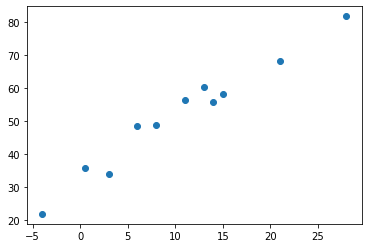

In [3]:
plt.scatter(t_c, t_u)

In [4]:
#データを収集したら、可視化、線形モデルをためす。
#線形モデル　t_c = w * t_u + b
#予測値と測定値の誤差が小さくなるようにモデルのパラメータ（ｗ：重みとｂ：バイアス）を推定する
#誤差の測定方法に損失関数を用いる
#この損失関数が最小になるようなw,bを見つけることを目標とする

## パラメータの推定と損失関数

In [5]:
#モデル作成
def model (t_u, w, b):
    return w* t_u + b

In [6]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [7]:
#パラメータの初期化
w = torch.ones(())
b = torch.zeros(())

In [8]:
w

tensor(1.)

In [9]:
t_p = model(t_u ,w ,b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [10]:
#この段階で損失
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

# ブロードキャスティング

In [11]:
#あるテンソルの１つが、他のテンソルよりも大きい次元の場合に他のテンソル全体にあるテンソルの次元に沿った
#計算がされる
import torch
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)
print(f"shape: x:{x.shape} y:{y.shape}")
print(f"z:{z.shape}, a:{a.shape}")
print("x * y:", (x*y).shape)
print("y * z:", (y*z).shape)
print("x * z * a:", (y*z*a).shape)

shape: x:torch.Size([]) y:torch.Size([3, 1])
z:torch.Size([1, 3]), a:torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
x * z * a: torch.Size([2, 3, 3])


In [12]:
z,a

(tensor([[1., 1., 1.]]),
 tensor([[[1.]],
 
         [[1.]]]))

In [13]:
#損失を小さくするためには

# 勾配降下法

In [14]:
#各パラメータに対する損失の変化率を計算し、損失が減少する方向に
#各パラメータを補正する

In [15]:
delta = 0.1

#wの変化が損失につながる
loss_rate_of_change_w = \
(loss_fn(model(t_u, w + delta, b),t_c)-
 loss_fn(model(t_u, w - delta, b), t_c)) /(2.0 * delta)

In [16]:
loss_rate_of_change_w 
#この損失の変化量が負の場合は損失を最小化するためにwを増加させる必要がある
#変化量が正の場合はwを減少させる必要がある

#どのくらい変化させた方がいいか
#損失の変化量に比例した変更をwに適用したらよいのではないか
#変化量を調整する係数を学習率と呼ぶ

tensor(4517.2974)

In [17]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

loss_rate_of_change_b = \
(loss_fn(model(t_u, w, b + delta),t_c)-
 loss_fn(model(t_u, w, b - delta),t_c))/(2.0 * delta)

In [69]:
b = b - learning_rate * loss_rate_of_change_b
b

tensor(278.8000)

In [18]:
#パラメータが複数あるモデルでは各パラメータの損失の個々の導関数を計算する
#この計算結果を導関数のベクトル、すなわち勾配と呼ぶ

In [19]:
#　導関数の計算
# 損失の導関数を計算するために、連鎖律をつかう
#　（入力）モデルの出力に関する導関数を、パラメータに関するモデルの導関数と掛け算してもとめる

In [33]:
#損失関数を再び定義
def loss_fn(t_p, t_c):
    squred_differs= (t_p -t_c)**2
    return squred_differs.mean()

In [34]:
loss_fn(t_p, t_c)

tensor(1763.8848)

In [28]:
#モデルは線形 dx*2 /dx = 2x
#損失の導関数は
def dloss_fn(t_p, t_c):
    dsq_diffs = 2*(t_p - t_c) / t_p.size(0)#除算は平均化のため
    return dsq_diffs

In [29]:
dloss_fn(t_p, t_c), t_p.shape

(tensor([6.4000, 7.6182, 7.8545, 9.8000, 8.2364, 7.4364, 5.6182, 4.6909, 7.7091,
         8.6182, 8.6182]),
 torch.Size([11]))

In [22]:
#model　は　w*t_u + b 

#このmodelの導関数は
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

In [47]:
#勾配の関数
#損失に勾配（導関数のベクトル）を掛ける
def  grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)#損失
    dloss_dw  = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db  = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])
    
#この出力を(学習率をかけてから）各パラメータに加えることで最適化

In [77]:
#反復して繰り返す必要がある
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs +1):
        w, b = params
        #順伝播
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        #逆伝播
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
        #パラメータの更新
        params = params - learning_rate * grad
        
        print('Epoch %d, Loss %f' % ( epoch, float(loss)))
        
    return params

In [79]:
training_loop(
    n_epochs = 20,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
Epoch 2, Loss 5802484.500000
Epoch 3, Loss 19408029696.000000
Epoch 4, Loss 64915905708032.000000
Epoch 5, Loss 217130525461053440.000000
Epoch 6, Loss 726257583152928129024.000000
Epoch 7, Loss 2429183416467662896627712.000000
Epoch 8, Loss 8125122549611731432050262016.000000
Epoch 9, Loss 27176882120842590626938030653440.000000
Epoch 10, Loss 90901105189019073810297959556841472.000000
Epoch 11, Loss inf
Epoch 12, Loss inf
Epoch 13, Loss inf
Epoch 14, Loss inf
Epoch 15, Loss inf
Epoch 16, Loss inf
Epoch 17, Loss inf
Epoch 18, Loss inf
Epoch 19, Loss inf
Epoch 20, Loss inf


tensor([1.3457e+35, 2.3704e+33])

In [ ]:
#損失が無限大になまった